In [1]:
# If you run this notebook on Google Colaboratory, uncomment the below to install automl_alex.
#!pip install -U -q automl-alex

In [1]:
import sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

import automl_alex
from automl_alex import DataPrepare
print(automl_alex.__version__)

1.2.25


In [2]:
RANDOM_SEED = 42

## Data

In [3]:
# add dataset whis more num features
dataset = fetch_openml(name='adult', version=1, as_frame=True)
dataset.target = dataset.target.astype('category').cat.codes

X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=0.2, random_state=RANDOM_SEED,)
X_train.shape, X_test.shape

((39073, 14), (9769, 14))

In [4]:
X_train.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country
37193,1,Private,50753.0,HS-grad,9.0,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,2,United-States
31093,2,State-gov,144351.0,Masters,14.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,2,United-States
33814,1,Local-gov,252217.0,12th,8.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,2,United-States


In [5]:
de = DataPrepare(
    normalization=False, # if you use Linar based models -> True (for Tree based models normalization is not needed)
    random_state=RANDOM_SEED,
    )
X_train = de.fit_transform(X_train)
X_test = de.transform(X_test)
X_train.shape, X_test.shape

Source data shape:  (39073, 14)
##################################################
! START preprocessing Data
- Auto detect cat features:  12
> Binary Features
> Clean Categorical Features
> Transform Categorical Features.
 - Encoder: HelmertEncoder ADD features: 123
 - Encoder: CountEncoder ADD features: 12
> CleanOutliers
Num of outlier detected: 560 in Feature fnlwgt
Proportion of outlier detected: 1.4 %
Num of outlier detected: 253 in Feature education-num
Proportion of outlier detected: 0.6 %
  No nans features
> Generate interaction Num Features
 ADD features: 3
> Reduce_Memory
Memory usage of dataframe is 25.34 MB
Memory usage after optimization is: 21.50 MB
Decreased by 15.1%
##################################################
Final data shape:  (39073, 154)
Total ADD columns: 140
##################################################
##################################################
! Start Transform Data
> Clean Binary Features
> Clean Categorical Features
> Transform Categorical

((39073, 154), (9769, 154))

In [6]:
X_train.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,CountEncoder_race,CountEncoder_capitalgain,CountEncoder_capitalloss,CountEncoder_hoursperweek,CountEncoder_native-country,fnlwgt_Is_Outliers_IQR,education-num_Is_Outliers_IQR,fnlwgt_/_education-num,fnlwgt_*_education-num,fnlwgt_-_education-num
0,1,1,50753.0,1,9.0,1,1,1,1,1,...,33425,35788,37253,22283,35123,0,0,5639.222168,456777.0,50744.0
1,2,2,144351.0,2,14.0,1,2,1,1,1,...,33425,35788,37253,22283,35123,0,0,10310.786133,2020914.0,144337.0
2,1,3,252217.0,3,8.0,1,3,1,1,1,...,33425,35788,37253,22283,35123,0,0,31527.125000,2017736.0,252209.0
3,3,1,69525.0,1,9.0,2,4,2,1,1,...,33425,35788,37253,3582,35123,0,0,7725.000000,625725.0,69516.0
4,3,4,28612.0,1,9.0,3,5,3,1,1,...,33425,35788,37253,1339,35123,0,0,3179.111084,257508.0,28603.0


# Classifier

## Model

In [7]:
# Libraries are currently available:
automl_alex.models.all_models

{'LightGBM': automl_alex.models.model_lightgbm.LightGBM,
 'KNeighbors': automl_alex.models.sklearn_models.KNeighbors,
 'LinearModel': automl_alex.models.sklearn_models.LinearModel,
 'SGD': automl_alex.models.sklearn_models.SGD,
 'RandomForest': automl_alex.models.sklearn_models.RandomForest,
 'ExtraTrees': automl_alex.models.sklearn_models.ExtraTrees,
 'XGBoost': automl_alex.models.model_xgboost.XGBoost,
 'CatBoost': automl_alex.models.model_catboost.CatBoost,
 'MLP': automl_alex.models.sklearn_models.MLP}

You can add a library if you wish.    
let's try LightGBM

In [8]:
from automl_alex import LightGBM, LightGBMClassifier

# We will use LightGBM for this dataset
model = LightGBM(type_of_estimator='classifier', random_state=RANDOM_SEED)

# or Simply
model = LightGBMClassifier(random_state=RANDOM_SEED)

it's simple, the logic is like in sklearn (.fit() => .predict())

In [9]:
model = model.fit(X_train, y_train)

In [10]:
predicts = model.predict_proba(X_test)
print('Test AUC: ', round(sklearn.metrics.roc_auc_score(y_test, predicts),4))

Test AUC:  0.906


In [12]:
# or just use .score()
score = model.score(
    X_test, y_test,
    metric=sklearn.metrics.roc_auc_score,
    metric_round=4,
    print_metric=True,
    )

roc_auc_score: 0.906


#### feature_importance

In [11]:
feature_importance = model.get_feature_importance(X_train)

<AxesSubplot:>

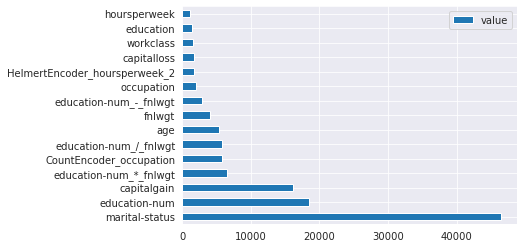

In [12]:
feature_importance.sort_values(by='value', ascending=False)[:15].plot(kind='barh')

#### model params

In [13]:
model.model_param

{'random_seed': 42,
 'num_iterations': 500,
 'verbose': -1,
 'device_type': 'cpu',
 'objective': 'binary'}

if we can optimize the model parameters the result can be improved

## Optimizing Parameters
In this library, I tried to simplify the process of optimizing and iterating parameters as much as possible. You just specify how much time you are willing to spend on optimization, and the library will select the rules for cross-validation, optimization depth, and other optimization parameters based on this time. The more time you give it, the better it will be able to select parameters.    

[RUS]
В этой библиотеке я постарался максимально упростить процесс оптимизации и перебора параметров. Вы просто указываете сколько вы готовы потратить времени на оптимизацию, а библиотека сама подберет правила кроссвалидации, глубины оптимизации и прочии параметры оптимизации исходя из этого времени. Чем больше времени вы ей дадите, тем более качественней она сможет подобрать параметры.

In [14]:
history = model.opt(
    X=X_train,
    y=y_train,
    timeout=600, # optimization time in seconds
    )

classifier optimize: maximize
One iteration takes ~ 3.2 sec
> Start Auto calibration parameters
> Start optimization with the parameters:
CV_Folds =  5
Score_CV_Folds =  2
Feature_Selection =  False
Opt_lvl =  1
Cold_start =  92.0
Early_stoping =  100
Metric =  roc_auc_score
Direction =  maximize
##################################################
Default model OptScore = 0.9068
optimize: maximize
[I 2021-02-23 23:47:23,160] A new study created in memory with name: no-name-19aedb13-8451-49cc-bde0-07d4b6c32d7d
Optimize: : 74it [10:04,  8.17s/it,  | Model: LightGBM | OptScore: 0.9141 | Best roc_auc_score: 0.9141 +- 0.005058]


In [15]:
model.model_param

{'random_seed': 42,
 'num_iterations': 500,
 'verbose': -1,
 'device_type': 'cpu',
 'objective': 'binary',
 'num_leaves': 4,
 'min_child_samples': 308}

In [16]:
model = model.fit(X_train, y_train)
predicts = model.predict(X_test)
print('Test AUC: ', round(sklearn.metrics.roc_auc_score(y_test, predicts),4))

Test AUC:  0.7748


In [17]:
history.head(5)

,score_opt,model_score,score_std,model_name,model_param,columns,cv_folds
21,0.9141,0.9141,0.005058,LightGBM,"{'random_seed': 42, 'num_iterations': 500, 've...","[age, workclass, fnlwgt, education, education-...",5
35,0.9138,0.9138,0.004850,LightGBM,"{'random_seed': 42, 'num_iterations': 500, 've...","[age, workclass, fnlwgt, education, education-...",5
57,0.9137,0.9137,0.004985,LightGBM,"{'random_seed': 42, 'num_iterations': 500, 've...","[age, workclass, fnlwgt, education, education-...",5
9,0.9136,0.9136,0.004647,LightGBM,"{'random_seed': 42, 'num_iterations': 500, 've...","[age, workclass, fnlwgt, education, education-...",5
11,0.9136,0.9136,0.004876,LightGBM,"{'random_seed': 42, 'num_iterations': 500, 've...","[age, workclass, fnlwgt, education, education-...",5


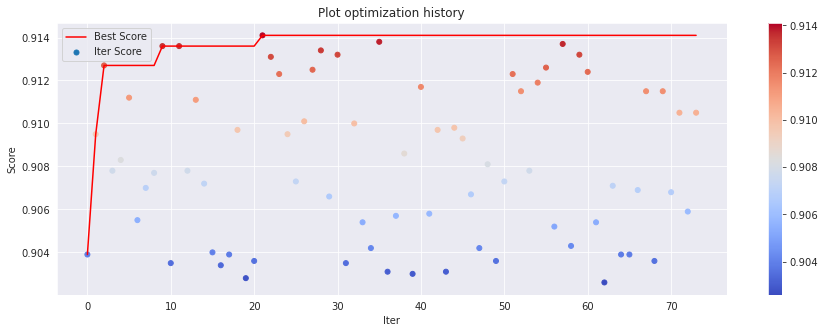

In [18]:
model.plot_opt_history()

## Cross Validation
Cross-validation is a method for evaluating an analytical model and its behavior on independent data. 
When evaluating the model, the available data is split into k parts. 
Then the model is trained on k − 1 pieces of data, and the rest of the data is used for testing. 
The procedure is repeated k times; in the end, each of the k pieces of data is used for testing. 
The result is an assessment of the effectiveness of the selected model with the most even use of the available data.

<img src="./img/cv.png" width="500">

In [19]:
result = model.cross_validation(
            X=X_train,
            y=y_train,
            X_test=None,
            folds=10, 
            score_folds=5,
            n_repeats=2,
            metric=sklearn.metrics.mean_squared_error,
            print_metric=True, 
            metric_round=4, 
            predict=False,
            get_feature_importance=False,
            )


 Mean Score mean_squared_error on 5 Folds: 0.1421 std: 0.004758


# How it works
first let's look at all the parameters available to us     
для начала посмотрим все доступные нам параметры

```python
model = LightGBMClassifier(
                    model_param=None, # default model parameters
                    type_of_estimator=None, # classifier or regression
                    gpu=False, 
                    verbose=0,
                    random_state=RANDOM_SEED
    )
```
**Let's look at the important parameters and what they give.**

### *model_param*
parameters of the model itself. As you already understood, to work with the library itself, I use some kind of wrapper, but *model_param* pass the settings directly to the model itself

In [20]:
model.model_param

{'random_seed': 42,
 'num_iterations': 500,
 'verbose': -1,
 'device_type': 'cpu',
 'objective': 'binary',
 'num_leaves': 4,
 'min_child_samples': 308}

## Optimization

```python
history = model.opt(X,y,
            timeout=200, # optimization time in seconds
            metric=sklearn.metrics.roc_auc_score, # any metric from sklearn
            metric_round=4,
            direction='maximize', # optimization direction
            combined_score_opt=True, # score_opt = score - std
            iterations=None,
            cold_start=30,
            auto_parameters=True,
            folds=10, # Cross-validation folds
            score_folds=2, # how many folds are actually used for score
            opt_lvl=2,  # depth of selection of parameters
            early_stoping=100,  # stop otimization if no better parameters are found through iterations
            feature_selection=False,
            iteration_check=True,
            verbose=1,)
```

To optimize hyperparameters used Optuna (https://optuna.org), but with some modifications. Inside Optuna uses the TPE algorithm.

good visualization from: https://medium.com/criteo-labs/hyper-parameter-optimization-algorithms-2fe447525903
<img src="https://miro.medium.com/max/2000/1*m1JYCHHhbmn6TCHcJIklZA.gif" width="800">


### *metric* and *direction*
you can use standard metrics from sklearn.metrics or add custom metrics. Be sure to indicate the direction of improvement of the metric     

вы можете использовать стандартные метрики из sklearn.metrics или добавить кастомную. Обязательно указывайте направление улучшения метрики

### *cv* folds and *score_folds*
In training, I use cross validation. But if we don’t have much time, then we go to the trick, and learn only part of the folds (score_folds)    

В обучении я использую кросс валидацию. Но если у нас мало времени то мы идем на хитрость, и обучаемся только на части фолдов (score_folds)


### *cold_start*
In the *cold_start* parameter, we specify how many iterations we give for this warm-up.
before the algorithm starts searching for optimal parameters, it must collect statistics on the represented space.this is why it starts in the randomsample solution at the beginning. The longer it works in this mode , the less likely it is to get stuck in the local minimum. But if you take too long to warm up, you may not have time to search with a more "smart" algorithm. Therefore, it is important to maintain a balance. 

перед тем как алгоритм начинает поиск оптимальных параметров, он должен собрать статистику по представляемому пространству, по этому в начале он запускаеться в решиме randomsample. Чем дольше он проработает в этом режиме - тем меньше вероятность что он застрянет в локальном минимуме. Но если слишком долго делать прогрев - то может не остаться времени на поиск с более "умным" алгоритмом. Поэтому важно соблюдать баланс. В параметре cold_start указываем сколько итераций мы даем на этот прогрев. 

### *opt_lvl*
by limiting the optimization time, we will have to choose how deep we should optimize the parameters. Perhaps some parameters are not so important and can only give a fraction of a percent. By setting the opt_lvl parameter, you control the depth of optimization.

in the code *automl_alex.models.model_lightgbm.LightGBM* you can find how parameters are substituted for iteration:

```python
....
def get_model_opt_params(self, trial, model, opt_lvl, len_data, metric_name,):
        """
        Return:
            dict of DistributionWrappers
        """
        model_param = model._init_default_model_param()
        ################################# LVL 1 ########################################
        if opt_lvl == 1:
            model_param['num_leaves'] = trial.suggest_int('lgbm_num_leaves', 2, 50,)
            
        if opt_lvl >= 1:
            if len_data > 1000:
                model_param['min_child_samples'] = trial.suggest_int('lgbm_min_child_samples', 2, \
                                                                        (len_data//100))
            else:
                model_param['min_child_samples'] = trial.suggest_int('lgbm_min_child_samples', 2, 7)

        ################################# LVL 2 ########################################
        if opt_lvl == 2:
            model_param['learning_rate'] = trial.suggest_int('lgbm_learning_rate', 1, 11)/100
            model_param['num_leaves'] = trial.suggest_int('lgbm_num_leaves', 2, 50,)
            model_param['num_iterations'] = trial.suggest_int('lgbm_num_iterations', 1, 5,)*100

        if opt_lvl >= 2:
            model_param['bagging_fraction'] = trial.suggest_discrete_uniform('lgbm_bagging_fraction', 0.4, 1., 0.1)
            if model_param['bagging_fraction'] < 1.:
                model_param['feature_fraction'] = trial.suggest_discrete_uniform('lgbm_feature_fraction', 0.3, 1., 0.1)
                model_param['bagging_freq'] = trial.suggest_int('lgbm_bagging_freq', 2, 11,)
        
        ################################# LVL 3 ########################################
        if opt_lvl == 3:
            model_param['learning_rate'] = trial.suggest_int('lgbm_learning_rate', 1, 100)/1000
            model_param['num_iterations'] = trial.suggest_int('lgbm_num_iterations', 1, 11,)*100
        
        if opt_lvl >= 3:
            model_param['num_leaves'] = trial.suggest_int('lgbm_num_leaves', 2, 100,)
        
        ################################# LVL 4 ########################################
        if opt_lvl == 4:
            model_param['learning_rate'] = trial.suggest_loguniform('lgbm_learning_rate', 1e-3, .1)

        if opt_lvl >= 4:
            model_param['boosting'] = trial.suggest_categorical('lgbm_boosting', ['gbdt', 'dart',])
            if model_param['boosting'] == 'dart':
                model_param['early_stopping_rounds'] = 0
                model_param['uniform_drop'] = trial.suggest_categorical('lgbm_uniform_drop', [True, False])
                model_param['xgboost_dart_mode'] = trial.suggest_categorical('lgbm_xgboost_dart_mode', [True, False])
                model_param['drop_rate'] = trial.suggest_loguniform('lgbm_drop_rate', 1e-8, 1.0)
                model_param['max_drop'] = trial.suggest_int('lgbm_max_drop', 0, 100)
                model_param['skip_drop'] = trial.suggest_loguniform('lgbm_skip_drop', 1e-3, 1.0)

            model_param['num_iterations'] = trial.suggest_int('lgbm_num_iterations', 1, 6,)*1000

            if model.type_of_estimator == 'classifier':
                model_param['objective'] = trial.suggest_categorical('lgbm_objective', 
                    [
                    'binary', 
                    'cross_entropy',
                    ])

            elif model.type_of_estimator == 'regression':
                model_param['objective'] = trial.suggest_categorical('lgbm_objective', 
                    [
                    'regression',
                    'regression_l1',
                    'mape',
                    'huber',
                    'quantile',
                    ])

        ################################# LVL 5 ########################################
        if opt_lvl >= 5:
            model_param['max_cat_threshold'] = trial.suggest_int('lgbm_max_cat_threshold', 1, 100)
            model_param['min_child_weight'] = trial.suggest_loguniform('lgbm_min_child_weight', 1e-6, 1.0)
            model_param['learning_rate'] = trial.suggest_loguniform('lgbm_learning_rate', 1e-5, .1)
            model_param['reg_lambda'] = trial.suggest_loguniform('lgbm_reg_lambda', 1e-8, 1.0)
            model_param['reg_alpha'] = trial.suggest_loguniform('lgbm_reg_alpha', 1e-8, 1.0)
            model_param['max_bin'] = trial.suggest_int('lgbm_max_bin', 1, 5,)*50
            #self.model_param['extra_trees'] = trial.suggest_categorical('lgbm_extra_trees', [True, False])
            model_param['enable_bundle'] = trial.suggest_categorical('lgbm_enable_bundle', [True, False])

        ################################# Other ########################################
        if model.type_of_estimator == 'classifier':
            if metric_name not in ['roc_auc_score', 'log_loss', 'brier_score_loss']:
                model_param['scale_pos_weight'] = trial.suggest_discrete_uniform('lgbm_scale_pos_weight', 0.1, 1., 0.1)

        return(model_param)
...
```

ограничивая время оптимизации, нам придется выбирать насколько глубоко мы должны оптимизировать параметры. Возможно некоторые параметры не так важны и могут дать лишь доли процента. Устанавливая параметр opt_lvl вы регулируете глубину оптимизации.

### *auto_parameters*
If we don't want to select anything, we just set *auto_parameters=True*. Then the algorithm itself will select, depending on the time allotted to it, the optimal values for:
* folds
* score_folds
* cold_start
* opt_lvl

Если мы не хотим ни чего подбирать, то просто устанавливаем auto_parameters=True. Тогда алгоритм сам подберет, в зависимости от выделенного ему времени, оптимальные значения этих параметров.

# Regression

In [21]:
from sklearn.datasets import load_boston
data = load_boston()
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(data.data), 
                                                    pd.DataFrame(data.target), 
                                                    test_size=0.15, 
                                                    random_state=RANDOM_SEED,)

X_train.shape, X_test.shape

((430, 13), (76, 13))

In [22]:
from automl_alex import LightGBM, LightGBMRegressor

# We will use LightGBM for this dataset
model = LightGBM(type_of_estimator='regression', random_state=RANDOM_SEED)

# or Simply
model = LightGBMRegressor(random_state=RANDOM_SEED)

In [23]:
model = model.fit(X_train, y_train)
predicts = model.predict(X_test)
print('Test MSE: ', sklearn.metrics.mean_squared_error(y_test, predicts))

Test MSE:  5.728586768420595


In [24]:
history = model.opt(X_train, y_train, timeout=600,)

regression optimize: minimize
One iteration takes ~ 0.4 sec
> Start Auto calibration parameters
> Start optimization with the parameters:
CV_Folds =  10
Score_CV_Folds =  5
Feature_Selection =  False
Opt_lvl =  3
Cold_start =  113.0
Early_stoping =  226.0
Metric =  mean_squared_error
Direction =  minimize
##################################################
Default model OptScore = 11.36
optimize: minimize
Optimize: : 3it [00:35, 11.81s/it,  | Model: LightGBM | OptScore: 0.9026 | Best mean_squared_error: 0.9026 +- 0.006932]


KeyboardInterrupt: 

In [ ]:
history.head(5)

In [ ]:
model.plot_opt_history()

In [ ]:
model.model_param

In [ ]:
model = model.fit(X_train, y_train)
predicts = model.predict(X_test)
print('Test MSE: ', sklearn.metrics.mean_squared_error(y_test, predicts))

# Advanced Use

In [ ]:
dataset = fetch_openml(name='adult', version=1, as_frame=True)
# convert target to binary
dataset.target = dataset.target.astype('category').cat.codes
dataset.data.head(5)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset.data, 
                                                    dataset.target,
                                                    test_size=0.2, 
                                                    random_state=RANDOM_SEED,)
X_train.shape, X_test.shape

In [ ]:
de = DataPrepare(random_state=RANDOM_SEED)
X_train = de.fit_transform(X_train)
X_test = de.transform(X_test)

In [ ]:
model = LightGBMClassifier(random_state=RANDOM_SEED)
model = model.fit(X_train, y_train)
predicts = model.predict(X_test)
print('Test metric: ', round(sklearn.metrics.log_loss(y_test, predicts),4))

## Advanced opt

In [ ]:
history = model.opt(
            X_train, y_train,
            metric=sklearn.metrics.log_loss, # log_loss
            direction='minimize', # changed optimization direction for log_loss
            combined_score_opt=True, # in 'minimize' score_opt = score + std
            timeout=1000, # sec
            auto_parameters=False, # try to set the rules ourselves
            folds=10,
            score_folds=3, # put 3 folds
            cold_start=50, # I plan > 200 iterations. 50 iterations are enough to evaluate the space
            opt_lvl=3,
            early_stoping=100, # stop otimization if no better parameters are found through iterations
            verbose=1,)

In [ ]:
model = model.fit(X_train, y_train)
predicts = model.predict(X_test)
print('Test metric: ', round(sklearn.metrics.log_loss(y_test, predicts),4))

In [ ]:
model.plot_opt_history()

## Feature Important from CV

In [ ]:
res = model.cross_validation(
            X=X_train,
            y=y_train,
            get_feature_importance=True,)
#res['Feature_importance']

In [ ]:
pd.Series(res['feature_importance'], index=res['feature_importance'].keys()).sort_values(ascending=False)[:15].plot(kind='barh')

## Predict from configs

In [ ]:
top5_models = history.drop_duplicates(subset=['model_score', 'score_std'], keep='last').head(5)
top5_models

In [ ]:
# let's load the 2nd model
model.model_param = top5_models['model_param'].iloc[1] 

In [ ]:
model = model.fit(X_train, y_train)
predicts = model.predict(X_test)
print('Test metric: ', round(sklearn.metrics.log_loss(y_test, predicts),4))

# Save & Load

### Save

In [ ]:
de.save('de_model_1',)

In [ ]:
model.save('model_1',)

In [ ]:
model.model_param

In [ ]:
predicts = model.predict(X_test)
print('Test metric: ', round(sklearn.metrics.log_loss(y_test, predicts),4))

### Load
you can restart the notebook to start from this place - to make sure

In [ ]:
import sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

import automl_alex
from automl_alex import DataPrepare
from automl_alex import LightGBM, LightGBMClassifier

RANDOM_SEED = 42
print(automl_alex.__version__)

In [ ]:
dataset = fetch_openml(name='adult', version=1, as_frame=True)
dataset.target = dataset.target.astype('category').cat.codes

X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=0.2, random_state=RANDOM_SEED,)

de = DataPrepare(random_state=RANDOM_SEED, verbose=0)
de = de.load('de_model_1', )
X_test = de.transform(X_test)

In [ ]:
model_new = LightGBMClassifier(random_state=RANDOM_SEED)
model_new = model_new.load('model_1',)

predicts = model_new.predict(X_test)
print('Test metric: ', round(sklearn.metrics.log_loss(y_test, predicts),4))

In [ ]:
model_new.model_param